In [23]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

# Assignment 2

## 1. Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based the matches.

### 1a. Detect Keypoints and Calculate Descriptors (10 points)

Load the sample image pair.

In [24]:
img1 = cv2.imread('data/graff1.png')
img2 = cv2.imread('data/graff2.png')

Since we have implemented the Harris corner detector from scratch in the weekly notebooks, in this problem we will use OpenCV to detect corners and get their descriptors. In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [25]:
orb = cv2.ORB_create()
kps1, des1 = orb.detectAndCompute(img1, None)
kps2, des2 = orb.detectAndCompute(img2, None)

Visualize locations of detected features.

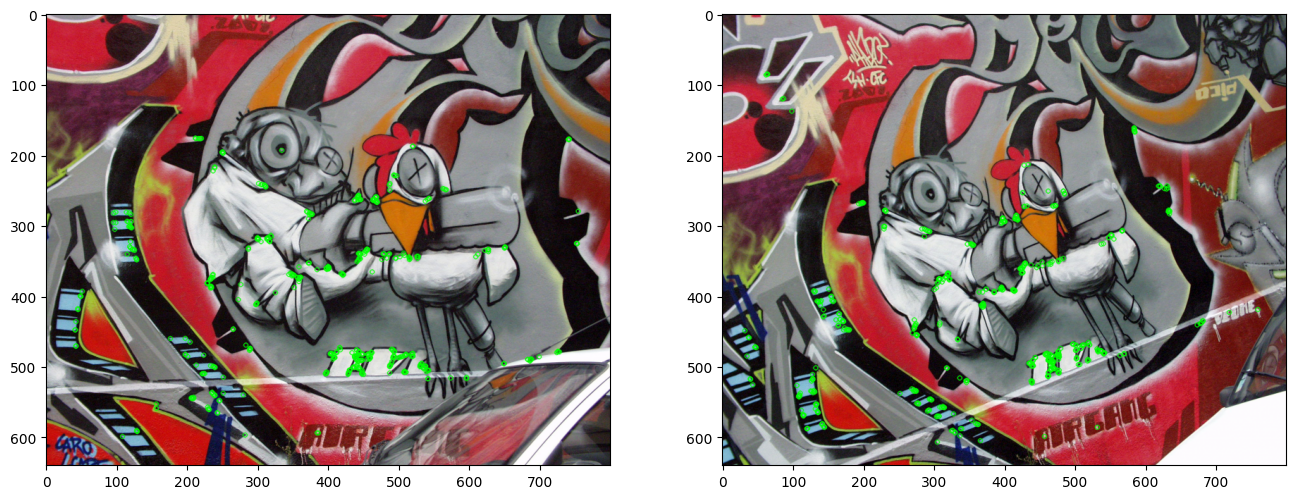

In [26]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### 1b. Match Keypoints (10 points)

Check out OpenCV's online docs and answer the following question:
- What attributes does each detected keypoint have? Briefly explain what they represent.

In [27]:
# Type your answer below:

# In OpenCV, each detected keypoint has attributes: pt, size, angle, response, octave and class_id.
 
#pt: Represents the 2D coordinates (x, y) of the keypoint in the image.​

#size: Tells us diameter of the meaningful neighborhood around the keypoint.​

#angle: Denotes the orientation of the keypoint in degrees, from 0 to 360.

#response: Tells us strength of the keypoints. This value is used to rank keypoints, higher responses indicate more prominent features.​

#octave: Specifies the pyramid layer from which the keypoint was extracted. This information is useful for algorithms that operate across multiple scales.​

#class_id: We can use id to cluster keypoints by the object they belong to. 

- What is the "apparent" size of each descriptor and what data type does it have? (You can easily find the answer by printing the `shape` and `dtype` of a descriptor.) The ORB [paper](https://ieeexplore.ieee.org/document/6126544) says "*we propose a very fast **binary** descriptor based on BRIEF, called ORB*." Based on this, what is the actual length of each binary descriptor?

In [28]:
# Type your answer below:
# Apparent Size and data type: ORB descriptors have a shape of (N, 32), where N is the number of keypoints, so each descriptor is stored as an array of 32 bytes.
# Actual Descriptor Length: The ORB paper states that ORB uses a 256-bit binary descriptor, OpenCV stores it efficiently as 32 uint8 numbers. 
# Thus, the descriptor appears as 32 bytes in memory, it is actually a 256-bit binary descriptor.

- Given two ORB descriptors, how should you measure their distance?

In [29]:
# Type your answer below:
# Since ORB descriptors are binary (256-bit), their distance is measured using the Hamming distance.
#Hamming distance counts the number of differing bits between two binary descriptors.
#It is efficient for binary descriptors because it can be computed using XOR followed by a bit count

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches.

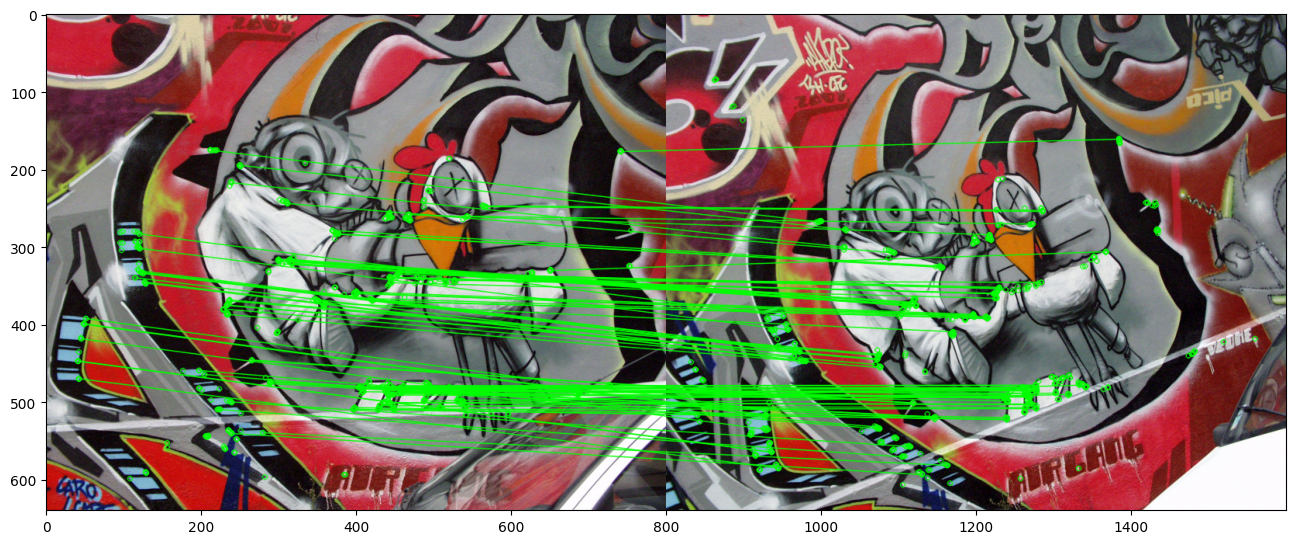

In [30]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance)
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None,
    matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

### 1c. Calculate Homography Between Matching Keypoints (20 points)

Implement the following function to calculate the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here.

You should implement this from from scratch and may **NOT** simply call functions from OpenCV or other libraries to solve this for you. 

In [31]:
def get_homography(pts1, pts2):
    """Estimate the homography between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    npoints = len(pts1)
    A = np.zeros((2 *npoints, 9))
    for i, (p1, p2) in enumerate(zip(pts1, pts2)):
        x1, y1 = p1
        x2, y2 = p2
        A[2*i] = [-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2]
        A[2*i + 1] = [0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2]
    U, S, Vt = np.linalg.svd(A)
    t = Vt[-1].reshape((3, 3))
    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]
t = get_homography(pts1, pts2)
print(t)

[[ 5.62558185e-03  1.98911992e-03 -2.67262500e-01]
 [-1.11606724e-03  5.92492523e-03  9.63565713e-01]
 [ 1.32247912e-06 -1.23451088e-07  6.31819957e-03]]


### 1d. Estimate Homography Between Images Using RANSAC (30 points)

Implement the following function to estimate the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them. You should implement RANSAC from scratch and may **NOT** simply call the corresponding functions in OpenCV or any other existing libraries.

In [32]:
import random


def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, threshold):
    """Estimate the transformation between two matching lists of keypoints 
    using RANSAC.
    
    Args:
    - kps1: A list of `cv2.KeyPoint` objects.
    - kps2: A list of `cv2.KeyPoint` objects.
    - matches: A list of `cv2.DMatch` objects representing the matches
          between `kps1` and `kps2`.
    - transform_func: Function used to estimate the transformation given
          matching points.
    - n_samples: The number of samples in each RANSAC trial.
    - n_trials: The total number of RANSAC trials.
    - threshold: The threshold used to determine whether a match is an
          inlier or not.
    
    Returns:
    - transform: The 3x3 transformation matrix that maps kps1 to kps2.
    - mask: A list of Boolean values representing whether the corresponding
          match is an inlier or not.
    """

    b_i = 0
    for _ in range(n_trials):
        sampled_matches = random.sample(matches, n_samples)
        
        pts1 = np.array([kps1[m.queryIdx].pt for m in sampled_matches])
        pts2 = np.array([kps2[m.trainIdx].pt for m in sampled_matches])

        t = get_homography(pts1, pts2)
        
        inliers = 0
        mask = []
        for m in matches:
            p1 = np.array([*kps1[m.queryIdx].pt, 1])
            p2 = np.array(kps2[m.trainIdx].pt)

            p1_transformed = t@p1
            p1_transformed/=p1_transformed[2] 

            error = np.linalg.norm(p1_transformed[:2]-p2)
            is_inlier = error<threshold
            inliers+=is_inlier
            mask.append(is_inlier)

        if inliers>b_i:
            b_i = inliers
            transform = t
            best_mask = mask
    return transform, mask

transform, mask = estimate_transformation_ransac(kps1, kps2, matches, get_homography, 4, 100, 10)
print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[ 5.66165589e-03  2.00590119e-03 -2.74247218e-01]
 [-1.10719663e-03  5.96747257e-03  9.61600237e-01]
 [ 1.35692216e-06 -1.69491311e-07  6.36660312e-03]].
8 out of 280 matches are inliers.


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

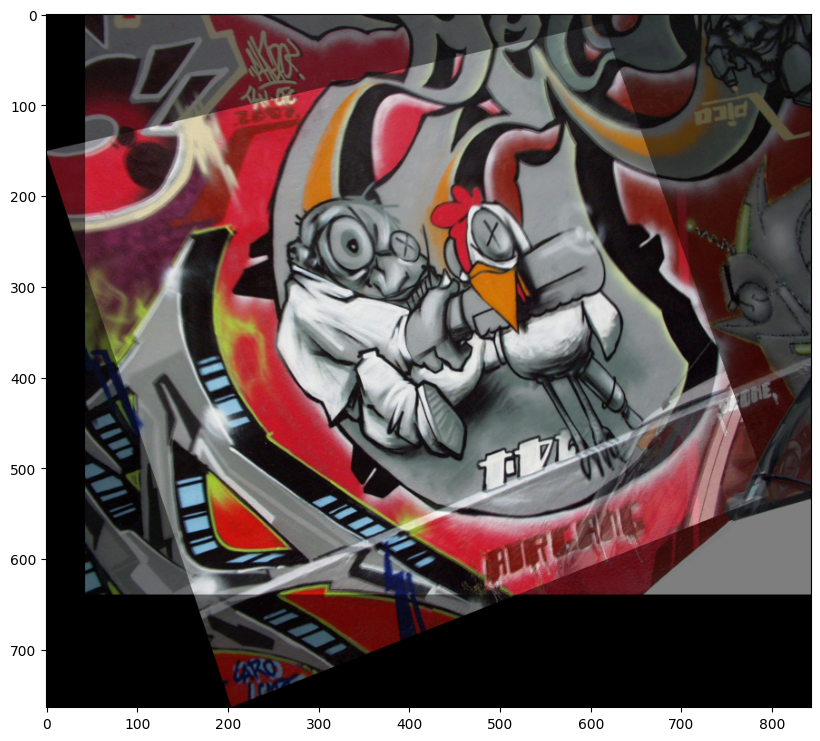

In [33]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Disparity Map (30 points)

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

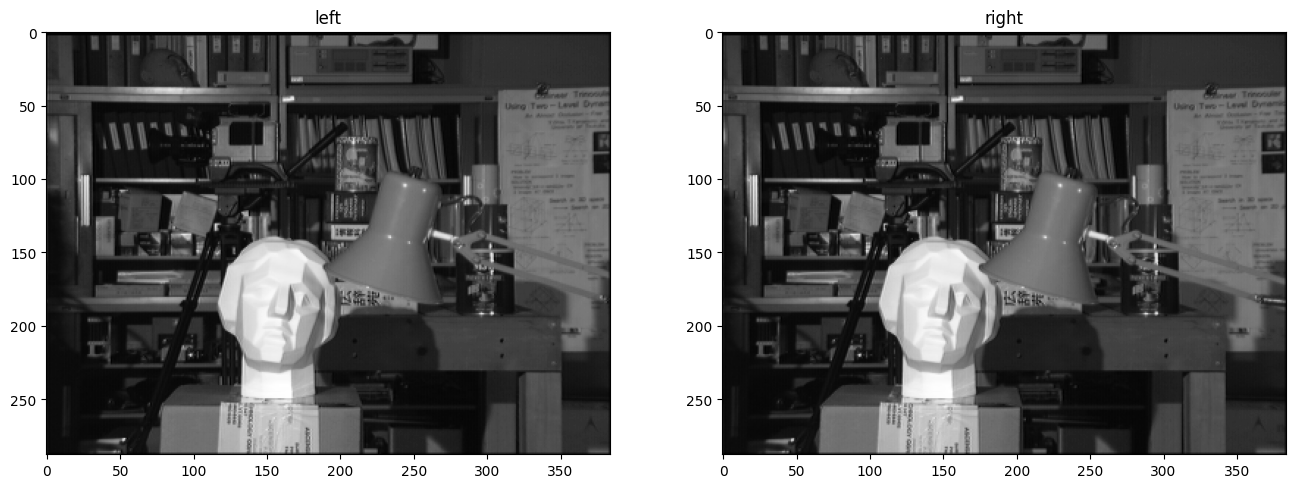

In [34]:
img1 = cv2.imread('data/left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('data/right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In the cell below, implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

Recall from the lectures we covered a naive implementation and a more efficient one. Please implement the efficient version.

In addition, operations on image arrays (such as shifting an image or comparing two image arrays) should be implemented in the vectorized form for more efficiency, instead of requiring two for-loops to loop through pixels one by one.

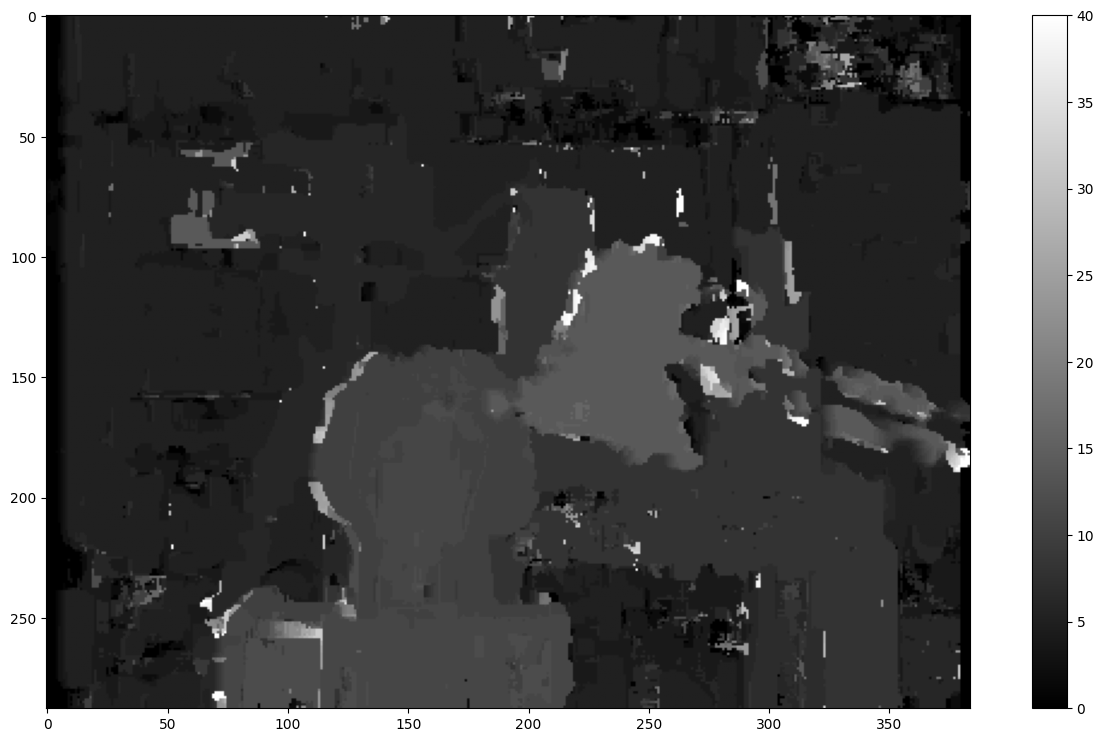

In [ ]:
from scipy.signal import convolve2d

disp = np.zeros_like(img1)
assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  
s = 7 

p = s//2
i1padded = np.pad(img1, pad_width=p)
i2padded = np.pad(img2, pad_width=p)

min_ssd = np.full((h, w), np.inf)
disp = np.zeros((h, w))
window = np.ones((s, s))

for k in range(dmin, dmax+1):
    i2shifted = np.zeros_like(i2padded)
    i2shifted[:, p+k:w+p] = i2padded[:, p:w+p-k]
    
    diff = (i1padded-i2shifted)**2

    ssd = convolve2d(diff, window, mode='valid')

    mask = ssd<min_ssd
    disp[mask] = k
    min_ssd[mask] = ssd[mask]

plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()